In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
# Define some arbitrary constants for our equations

NUTRIENT_INTAKE_RATE = 0.5
LITTERING_RATE = 0.3
WFPS = 1
L2 = lambda x: x
W = lambda t: WFPS

In [3]:
def F(t, x):
    x_0 = LITTERING_RATE*x[1] - L2(W(t))*x[0]
    x_1 = NUTRIENT_INTAKE_RATE*x[1]*x[2] - LITTERING_RATE*x[1]
    x_2 = L2(W(t))*x[0] - NUTRIENT_INTAKE_RATE*x[1]*x[2]
    
    return [x_0, x_1, x_2]
    
t_eval = np.arange(0, 100, 0.01)
sol = solve_ivp(F, [0, 100], [0.5, 0.5, 0.0], t_eval=t_eval)

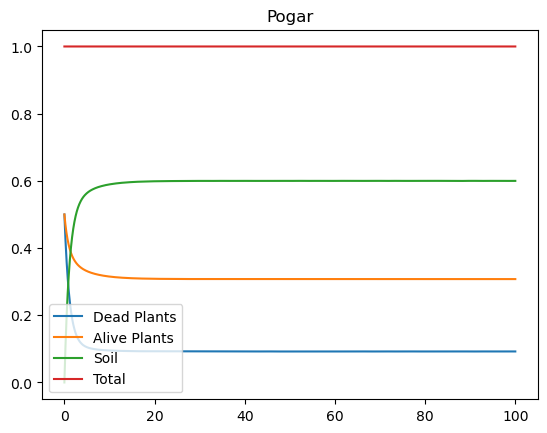

In [4]:
plt.plot(t_eval, sol.y.T[:, 0], label="Dead Plants")
plt.plot(t_eval, sol.y.T[:, 1], label="Alive Plants")
plt.plot(t_eval, sol.y.T[:, 2], label="Soil")
plt.plot(t_eval, sol.y.T[:, 0]+sol.y.T[:, 1]+sol.y.T[:, 2], label="Total")
plt.title("Pogar")
plt.legend()
plt.show()

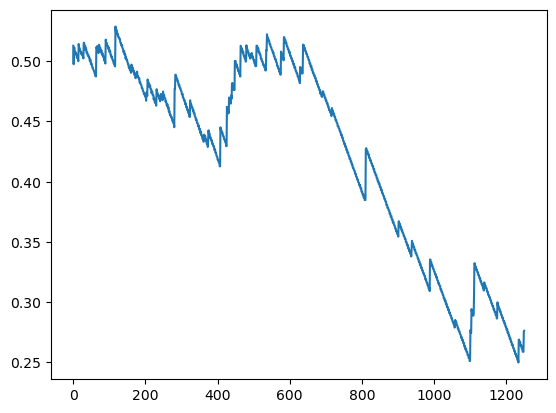

In [5]:
### Define some arbitrary constants for our equations

NUTRIENT_INTAKE_RATE = 0.5
LITTERING_RATE = 0.3
WFPS = 0.3
L2 = lambda x: x

from water import water

result = water(500, 0, 10000, 1, [0.2, 4, 3], [0.6, 4, 3])
plt.plot(result)

W = lambda t: WFPS*np.sin(t/100) + WFPS

In [16]:
from copy import copy, deepcopy

TIME_PERIOD = 100000
SPECIES_COUNT = 20
NUTRIENT_COUNT = 4

input_state = np.empty((NUTRIENT_COUNT, SPECIES_COUNT + 2))

# We now populate our input state
for nutrient in range(NUTRIENT_COUNT):
    for species in range(SPECIES_COUNT):
        input_state[nutrient][species] = 0.02
        
soil_uptake_params = np.empty((NUTRIENT_COUNT, SPECIES_COUNT))
littering_params = np.empty((NUTRIENT_COUNT, SPECIES_COUNT))
preference_params = np.empty((NUTRIENT_COUNT, SPECIES_COUNT))

AVG_LITTER_RATE = 0.07/(365*3)
AVG_UPTAKE_RATE = 0.14/(365*3)

# Populate uptake and littering params
for nutrient in range(NUTRIENT_COUNT):
    for species in range(SPECIES_COUNT):
        soil_uptake_params[nutrient][species] = np.random.uniform(0.9*AVG_UPTAKE_RATE, 1.1*AVG_UPTAKE_RATE)
        littering_params[nutrient][species] = np.random.uniform(0.9*AVG_LITTER_RATE, 1.1*AVG_LITTER_RATE)
        preference_params[nutrient][species] = np.random.uniform(0.5, 1.5)

        
for nutrient in range(NUTRIENT_COUNT):
    input_state[nutrient][-1] = 0.0 # Start off with zero dead plants
    input_state[nutrient][-2] = 0.6 # Start off with 1-P nutrients in the soil
    

In [17]:
  def F(t, state_space):
    # print(t)
    state_space = np.reshape(state_space, (NUTRIENT_COUNT, SPECIES_COUNT + 2))
    return_state = np.empty((NUTRIENT_COUNT, SPECIES_COUNT+2))
    
    #calculate biomass
    B_vec = np.empty([SPECIES_COUNT, 1])
    for species in range(SPECIES_COUNT):
        min_nutrient = min([preference_params[n][species]*state_space[n][species] for n in range(NUTRIENT_COUNT)])
        B_vec[species] = min_nutrient 
                     
    # Calculate plant derivatives
    for nutrient in range(NUTRIENT_COUNT):
        for species in range(SPECIES_COUNT):
            return_state[nutrient][species] = \
            soil_uptake_params[nutrient][species] * B_vec[species]\
            * state_space[nutrient][-2] - littering_params[nutrient][species]*B_vec[species]\
            * state_space[nutrient][species]
            
    # Calculate other derivatives
    for nutrient in range(NUTRIENT_COUNT):
        # Soil
        return_state[nutrient][-2] = L2(W(t))*state_space[nutrient][-1] \
        - sum([soil_uptake_params[nutrient][s] * B_vec[s] for s in range(SPECIES_COUNT)])\
        * state_space[nutrient][-2]
        
        # Dead
        return_state[nutrient][-1] = sum([littering_params[nutrient][s]*B_vec[s]*state_space[nutrient][s] \
                                          for s in range(SPECIES_COUNT)]) - L2(W(t)) * state_space[nutrient][-1]
        
        
    return return_state.flatten()
        
t_eval = np.arange(0, TIME_PERIOD, 0.1)
sol = solve_ivp(F, [0, TIME_PERIOD], input_state.flatten(), t_eval=t_eval)

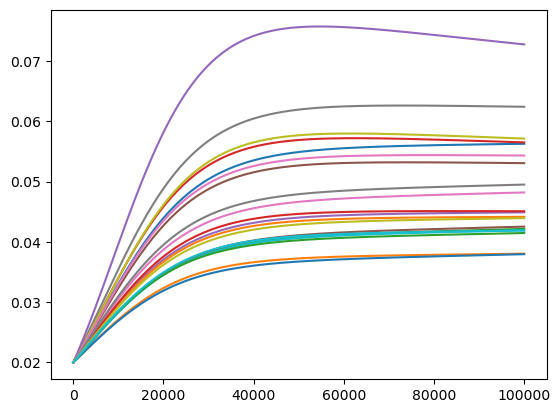

In [18]:
rolled_sol = np.reshape(sol.y, (NUTRIENT_COUNT, SPECIES_COUNT+2, TIME_PERIOD*100))

for species in range(SPECIES_COUNT):
    plt.plot(t_eval, rolled_sol[0, species, :])
    
#plt.show()